In [15]:
from rl.gnn import MyModel, RGCN
import torch
from data.graph_loader import GraphLoader, load_highschool
from torch_geometric.utils import to_networkx, to_undirected, degree
from torch_geometric.data import Data

############################ DATA LOADING #########################
device = torch.device("cuda:3")
# edge_index = load_highschool()
# num_nodes = 70
# edge_index = to_undirected(edge_index, num_nodes=num_nodes)
# node_idx = torch.arange(num_nodes).to(device)
# graph = Data(x=node_idx.cpu(), edge_index=edge_index)
# nx_graph = to_networkx(graph)
# node_degrees = degree(graph.edge_index[0], num_nodes=num_nodes)
# random_walk_pe = torch.load("datasets/random_walk_pe_highschool_64.pt").to(device)

def create_clique(num_nodes):
    edge_index = []
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            edge_index.append([i, j])
            edge_index.append([j, i])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.ones((num_nodes, 1))  # Node features
    return Data(x=x, edge_index=edge_index)

# Number of cliques and nodes per clique
num_cliques = 5
nodes_per_clique = 5

# Create all cliques and combine them into a single graph
all_nodes = []
all_edges = []

for k in range(num_cliques):
    clique = create_clique(nodes_per_clique)
    clique_edge_index = clique.edge_index + k * nodes_per_clique
    all_nodes.append(clique.x)
    all_edges.append(clique_edge_index)

x = torch.cat(all_nodes, dim=0)
edge_index = torch.cat(all_edges, dim=1)

graph = Data(x=torch.eye(num_cliques*nodes_per_clique), edge_index=edge_index)
nx_graph = to_networkx(graph)
num_nodes = 25
node_idx = torch.arange(num_nodes).to(device)

############################ MODEL #########################
hidden_dim = 25
lr = 1e-4
q_value = MyModel(num_nodes=num_nodes,
    hidden_dim=hidden_dim).to(device)
target_q_value = MyModel(num_nodes=num_nodes,
    hidden_dim=hidden_dim).to(device)
# q_value = RGCN(
#     num_relations=2,
#     input_dim=num_nodes,
#     hidden_dim=hidden_dim,
#     ).to(device)
# target_q_value = RGCN(
#     num_relations=2,
#     input_dim=num_nodes,
#     hidden_dim=hidden_dim,
#     ).to(device)

# initailize the embeddings and models
# q_value.embeddings.weight.data = random_walk_pe
target_q_value.load_state_dict(q_value.state_dict())

# Optimizer
optimizer = torch.optim.AdamW(q_value.parameters(), lr=lr)

import numpy as np
import random
from collections import deque
from typing import Dict, List, Tuple
from utils.segment_tree import MinSegmentTree, SumSegmentTree

class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(
        self, 
        obs_dim: int, 
        size: int, 
        batch_size: int = 32, 
        n_step: int = 1, 
        gamma: float = 0.99
    ):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.int_)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.full(size, False, dtype=bool)
        
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0
        
        # for N-step Learning
        self.n_step_buffer = deque(maxlen=n_step)
        self.n_step = n_step
        self.gamma = gamma

    def store(
        self, 
        obs: np.ndarray, 
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool]:
        transition = (obs, act, rew, next_obs, done)
        self.n_step_buffer.append(transition)

        # single step transition is not ready
        if len(self.n_step_buffer) < self.n_step:
            return ()
        
        # make a n-step transition
        rew, next_obs, done = self._get_n_step_info(
            self.n_step_buffer, self.gamma
        )
        obs, act = self.n_step_buffer[0][:2]
        
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
        
        return self.n_step_buffer[0]

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)

        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
            # for N-step Learning
            indices=idxs,
        )
    
    def sample_batch_from_idxs(
        self, idxs: np.ndarray
    ) -> Dict[str, np.ndarray]:
        # for N-step Learning
        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
        )
    
    def _get_n_step_info(
        self, n_step_buffer: deque, gamma: float
    ) -> Tuple[np.int64, np.ndarray, bool]:
        """Return n step rew, next_obs, and done."""
        # info of the last transition
        rew, next_obs, done = n_step_buffer[-1][-3:]

        for transition in reversed(list(n_step_buffer)[:-1]):
            r, n_o, d = transition[-3:]

            rew = r + gamma * rew * (1 - d)
            next_obs, done = (n_o, d) if d else (next_obs, done)

        return rew, next_obs, done

    def __len__(self) -> int:
        return self.size

import scipy.sparse as sparse
import networkx as nx

class NodeImmunization(object):
    def __init__(
        self, 
        budget,
        device,
        graph,
        oracle_calls = 100,
        ):
        self.budget = budget
        self.oracle_calls = oracle_calls
        self.device = device
        self.nx_g = graph
        
        
    def step(self, action):
        reward, done = self._take_action(action)    
        ob = self._build_ob()

        return ob, reward, done
    
    def _take_action(self, action):
        
        
        # compute reward and solution
        previous_deleted_nodes = (self.x == 1).long()
        reward = self._reward_compute(previous_deleted_nodes, action)
        self.x[action] = 1
        done = self._check_done()

        return reward, done

    def _reward_compute(self, node_index, action):
        
        # node_index = node_index.squeeze().cpu().numpy()
        # node_index = node_index.nonzero()[0]
        
        mask = torch.where(node_index)[0].cpu().numpy()
        mask[action] = 1
        eigen_drop = compute_total_degree(self.nx_g, mask)
        
        new_reward = eigen_drop - self.old_reward
        if new_reward< 0:
            new_reward = 0

        self.old_reward = eigen_drop

        # new_reward = SV(self.nx_g, node_index, action)

        
            
        return new_reward

    def _check_done(self):
        num_deleted = (self.x == 1).float()
        return num_deleted.sum() == self.budget
            
    def _build_ob(self):
        return self.x.float()
        
    def register(self, g, num_samples = 1):
        self.g = g
        self.num_samples = num_samples
        self.g.to(self.device)
        self.old_reward = 0
        
        num_nodes = self.g.x.shape[0]
        self.x = torch.zeros(
            num_nodes, 
            num_samples, 
            dtype = torch.long, 
            device = self.device
            )
        
        # self.evaluation = ShieldValue(self.nx_g, self.device)
        ob = self._build_ob()      
        return ob
    
def compute_total_degree(graph, nodes):
    unique_neighbors = set()
    for node in nodes:
        unique_neighbors.update(graph.neighbors(node))
    # import pdb; pdb.set_trace()
    # Remove the nodes of interest from the unique neighbors set
    unique_neighbors.update(nodes)
    return len(unique_neighbors)

class ShieldValue(torch.nn.Module):
    def __init__(self, graph, device) -> None:
        super().__init__()
        self.device = device
        self.G = graph
        self.adj = nx.adjacency_matrix(self.G, dtype=float).tolil()
        eigenval, eigenvec = sparse.linalg.eigsh(self.adj, k=1, which='LA')
        self.eigenval = eigenval.item()
        self.ori_eigenval = eigenval.item()

        self.A = torch.from_numpy(self.adj.todense()).to(device)
        self.eigenvec = torch.from_numpy(eigenvec).to(device).squeeze()


    def forward(self, node_index):
        eigenval = self.eigenval
        eigenvec = self.eigenvec
        adj = self.A

        mask = (node_index == 1).squeeze()
        term1 = 2*eigenval*(mask*(eigenvec**2)).sum()
        masked_eigenvec = (eigenvec * mask).reshape(-1,1)
        term2 = (adj * (masked_eigenvec @ masked_eigenvec.T)).sum()
        eigendrop = term1 - term2
        return eigendrop.item()
    
def SV(graph, node_index, action):
    adj = nx.adjacency_matrix(graph, dtype=float).tolil()
    mask = (node_index == 1).squeeze().cpu().numpy()
    adj[mask, :] = 0
    adj[:, mask] = 0
    eigenval, eigenvec = sparse.linalg.eigsh(adj, k=1, which='LA')

    device = node_index.device

    eigenval = eigenval.item()
    adj = torch.from_numpy(adj.todense()).to(device)
    eigenvec = torch.from_numpy(eigenvec).to(device).squeeze()
    mask = torch.zeros_like(node_index).squeeze()
    mask[action] = 1

    term1 = 2*eigenval*(mask*(eigenvec**2)).sum()
    masked_eigenvec = (eigenvec * mask).reshape(-1,1)
    term2 = (adj * (masked_eigenvec @ masked_eigenvec.T)).sum()
    eigendrop = term1 - term2
    return eigendrop.item()



In [16]:
from copy import deepcopy as dc
from torch_geometric.loader import DataLoader

verbose = True
discount_rate = 1
max_episodes = 2000
max_epsilon = 1.0
min_epsilon = 0.01
epsilon_decay = 1 / 900
epsilon = 1.0
batch_size = 32
max_grad_norm = 1.0
update_target_iters = 100
budget = 5

# Enviroment
env = NodeImmunization(
    budget=budget,
    device=device,
    graph=nx_graph,
    )

# Replay Buffer
buffer = ReplayBuffer(num_nodes, size=5000, batch_size=batch_size, gamma=discount_rate)

update_iters = 0
eigen_vals = []
total_loss = []
neighbors = []
for episode in range(1, max_episodes+1):
        ob = env.register(graph)
        done = False
        mean_loss = []
        while not done:
            # Run policy to collect data
            q_value.eval()
            with torch.no_grad():
                mask = (env.x == 0).squeeze()
                
                node_value = q_value(node_idx, graph.edge_index, ob)
                
                # choose action
                if epsilon > np.random.random():
                    randomly_selected_node = random.choice(range(mask.sum().item()))
                    index = mask.nonzero().squeeze()[randomly_selected_node]
                    action = index
                else:
                    selected_node = torch.argmax(node_value[mask]).item()
                    index = mask.nonzero().squeeze()[selected_node]
                    action = index
                    
                # take action
                next_ob, reward, done = env.step(action)
                
                # store the trajectory
                buffer.store(
                    ob.squeeze().cpu().numpy(),
                    action.item(),
                    reward,
                    next_ob.squeeze().cpu().numpy(),
                    done.item()
                )
                ob = next_ob
            #################################################################



            count = 0
            avg_loss = 0
            for iters in range(1):
                # only start to train when we have enough samples
                if buffer.size - 8 > buffer.batch_size:

                    ########## data preparation ###############################################
                    verbose = True
                    batch_data = buffer.sample_batch()
                    batch_dataset = []

                    for i in range(batch_data["obs"].shape[0]):
                        G = dc(graph).cpu()
                        G.x = node_idx.cpu()
                        next_obs = torch.from_numpy(batch_data['next_obs'][i])
                        obs = torch.from_numpy(batch_data['obs'][i])
                        G.obs = obs
                        G.next_obs = next_obs
                        G.rews = torch.tensor([batch_data['rews'][i]])
                        G.y = torch.zeros(num_nodes, 1).squeeze()
                        G.y[int(batch_data['acts'][i])] = 1
                        G.done = torch.tensor([batch_data['done'][i]], dtype=torch.bool)
                        G.indices = batch_data["indices"][i]
                        # G.weights = batch_data["weights"][i]
                
                        batch_dataset.append(G)
                    #########################################################################
                    


                    ################## Q-learning #############################################
                    loader1 = DataLoader(batch_dataset, batch_size=batch_size, shuffle=False)
                    for batch in loader1:
                        # Target
                        batch = batch.to(device)
                        with torch.no_grad():
                            
                            target = target_q_value(batch.x, batch.edge_index, batch.next_obs).detach()
                            predicted_value_next = q_value(batch.x, batch.edge_index, batch.next_obs).detach()
                            
                            actions = []
                            for i in range(len(batch.rews)):
                                mask = (batch.batch == i).squeeze()
                                feasible_actions = (batch.obs[mask] == 0).squeeze()
                                selected_node = torch.argmax(predicted_value_next[mask][feasible_actions]).item()
                                index = feasible_actions.nonzero().squeeze()[selected_node].item()
                                index = mask.nonzero().squeeze()[index].item()
                                actions.append(index)   # choose a feasible action

                            discounted_rewards = discount_rate*target[actions].squeeze()
                            discounted_rewards[batch.done] = 0      # set to 0 if it it the last step
                            target = batch.rews + discounted_rewards

                        # Train
                        q_value.train()
                        predicted_value = q_value(batch.x, batch.edge_index, batch.obs) 
                        elementwise_loss = 0.5*((target - predicted_value[batch.y==1].squeeze())**2)
                    
                    loss = (elementwise_loss).sum()
                    avg_loss += loss.detach().item()
                    count += 1

                    optimizer.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(
                            q_value.parameters(), 
                            max_grad_norm
                            )
                    optimizer.step()
                    ######################################################################################
                    started = True
                else:
                    started = False
                    continue
            # logging loss
            mean_loss.append(avg_loss/(count+1e-8))

            # Set two networks equal for every "update_target_iters" steps
            update_iters += 1
            if update_iters % update_target_iters == 0:
                target_q_value.load_state_dict(q_value.state_dict())
                update_iters = 0
                # epsilon = 0.9

            # Polyak averaging
            # target_q_value.load_state_dict(polyak_avg(target_q_value.state_dict(), q_value.state_dict()))

        # Update epsilon
        epsilon = max(
            min_epsilon, epsilon - (
                max_epsilon - min_epsilon
            ) * epsilon_decay
        )

        if started:
            # logging the true eigen drop
            G = dc(nx_graph)
            G.remove_nodes_from(torch.where(ob == 1)[0].cpu().numpy())
            adj = nx.adjacency_matrix(G, dtype=float)
            eigenval, _ = sparse.linalg.eigsh(adj, k=1, which='LA')
            eigen_vals.append(eigenval)
            total_loss.append(np.mean(mean_loss))
            neighbors.append(compute_total_degree(nx_graph, torch.where(ob == 1)[0].cpu().numpy()))
            
            if verbose:
                # torch.save(q_value.state_dict(), model_path)
                # writer.writerow({
                #     'episode': episode, 
                #     'avg loss': np.mean(mean_loss),
                #     'eigenval': eigenval.item()})
                print("Episode: {}/{} , Avg Loss: {:.4f}, Eigenval: {:.4f}, Neighbor: {:.4f}, Mean: {:.4f}, STD: {:.4f}".format(
                episode, max_episodes, 
                np.mean(mean_loss), 
                eigenval.item(), 
                compute_total_degree(nx_graph, torch.where(ob == 1)[0].cpu().numpy()),
                predicted_value.detach().mean().item(),
                predicted_value.detach().std().item()
                )
                )


/tmp/ipykernel_1282319/292867754.py:89: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  G.done = torch.tensor([batch_data['done'][i]], dtype=torch.bool)


Episode: 9/2000 , Avg Loss: 342.7129, Eigenval: 4.0000, Neighbor: 15.0000, Mean: -0.2036, STD: 0.5173
Episode: 10/2000 , Avg Loss: 333.2426, Eigenval: 4.0000, Neighbor: 20.0000, Mean: -0.1947, STD: 0.5175
Episode: 11/2000 , Avg Loss: 340.4869, Eigenval: 4.0000, Neighbor: 15.0000, Mean: -0.1846, STD: 0.5178
Episode: 12/2000 , Avg Loss: 337.2996, Eigenval: 4.0000, Neighbor: 20.0000, Mean: -0.1748, STD: 0.5181
Episode: 13/2000 , Avg Loss: 327.6081, Eigenval: 4.0000, Neighbor: 15.0000, Mean: -0.1647, STD: 0.5184
Episode: 14/2000 , Avg Loss: 332.4951, Eigenval: 4.0000, Neighbor: 20.0000, Mean: -0.1529, STD: 0.5186
Episode: 15/2000 , Avg Loss: 349.9607, Eigenval: 4.0000, Neighbor: 20.0000, Mean: -0.1447, STD: 0.5186
Episode: 16/2000 , Avg Loss: 300.3804, Eigenval: 4.0000, Neighbor: 20.0000, Mean: -0.1350, STD: 0.5187
Episode: 17/2000 , Avg Loss: 343.4356, Eigenval: 4.0000, Neighbor: 20.0000, Mean: -0.1255, STD: 0.5185
Episode: 18/2000 , Avg Loss: 305.0954, Eigenval: 4.0000, Neighbor: 20.0000

KeyboardInterrupt: 

In [9]:
import heapq

def top_k_indices(numbers, k):
    # Find the top-k elements
    top_k_elements = heapq.nlargest(k, numbers)
    
    # Find the indices of these elements in the original list
    top_k_indices = [i for i, num in enumerate(numbers) if num in top_k_elements]
    
    # Handle cases where the same number appears multiple times
    seen = set()
    unique_top_k_indices = []
    for idx in top_k_indices:
        if numbers[idx] in seen:
            continue
        unique_top_k_indices.append(idx)
        seen.add(numbers[idx])
        if len(unique_top_k_indices) == k:
            break
    
    return unique_top_k_indices

In [74]:

from copy import deepcopy as dc

def compute_eigenval(nx_graph, node_idx):
    G = dc(nx_graph)
    G.remove_nodes_from(node_idx)
    # import pdb; pdb.set_trace()
    adj = nx.adjacency_matrix(G, dtype=float)
    after_eigenval, _ = sparse.linalg.eigsh(adj, k=1, which='LA')
    return after_eigenval

In [75]:
# NS
budget = 5
ob = torch.zeros(num_nodes).to(device)
actions = []
for i in range(budget):
    best_res = 0
    for j in torch.where(ob==0)[0]:
        # import pdb; pdb.set_trace()
        tmp = SV(nx_graph, ob, j.item())
        if best_res < tmp:
            best_res = tmp
            action = j.item()
    ob[action] = 1
    actions.append(action)
    eigenval = compute_eigenval(nx_graph, actions)
    print(f"{action} nodes deleted. Eigenval: {eigenval}")

27 nodes deleted. Eigenval: [8.94130557]
6 nodes deleted. Eigenval: [8.40438329]
45 nodes deleted. Eigenval: [7.95843545]
3 nodes deleted. Eigenval: [7.74165463]
36 nodes deleted. Eigenval: [7.25580141]


In [66]:
tmp

0.08924121104986305

In [52]:
ob = torch.zeros(num_nodes).to(device)

In [19]:
edge_index = load_highschool()
num_nodes = 70
edge_index = to_undirected(edge_index, num_nodes=num_nodes)
node_idx = torch.arange(num_nodes).to(device)
graph = Data(x=node_idx.cpu(), edge_index=edge_index)
nx_graph = to_networkx(graph)
node_degrees = degree(graph.edge_index[0], num_nodes=num_nodes)
random_walk_pe = torch.load("datasets/random_walk_pe_highschool_64.pt").to(device)

In [20]:
nodes_with_largest_degree = sorted(nx_graph.degree, key=lambda x: x[1], reverse=True)[:5]
nodes = [node for node, degree in nodes_with_largest_degree]


compute_total_degree(nx_graph, nodes)

45

In [22]:
node_degrees

tensor([ 7.,  5.,  5., 14., 13., 13., 13.,  3.,  9.,  2.,  6.,  9.,  8.,  6.,
        10., 11.,  5.,  6., 10.,  6.,  9.,  8.,  5.,  3.,  5.,  6., 13., 19.,
         3.,  7.,  8.,  9.,  9., 10.,  7.,  9., 15.,  7.,  9., 13.,  7.,  8.,
         8.,  9.,  8., 15.,  2.,  9.,  5.,  8.,  3.,  5.,  7.,  9.,  4., 12.,
         6.,  7.,  8.,  2.,  6.,  7., 13.,  7.,  7.,  6.,  9.,  8.,  3.,  5.])

In [21]:
nodes_with_largest_degree

[(27, 38), (36, 30), (45, 30), (3, 28), (4, 26)]

In [37]:
# TEST

q_value.eval()
ob = env.register(graph)
done = False
mean_loss = []
while not done:
    # Run policy to collect data
    with torch.no_grad():
        mask = (env.x == 0).squeeze()
        
        node_value = q_value(node_idx, graph.edge_index, ob)
        
        # choose action
        if epsilon > np.random.random():
            randomly_selected_node = random.choice(range(mask.sum().item()))
            index = mask.nonzero().squeeze()[randomly_selected_node]
            action = index
        else:
            selected_node = torch.argmax(node_value[mask]).item()
            index = mask.nonzero().squeeze()[selected_node]
            action = index
            
        # take action
        next_ob, _, done = env.step(action)
        ob = next_ob
    
compute_total_degree(nx_graph, ob.squeeze().nonzero().cpu().numpy().squeeze())

25

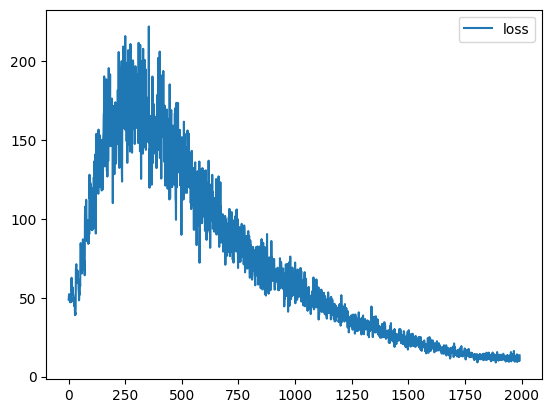

In [12]:
import matplotlib.pyplot as plt

# plt.plot(neighbors, label="neighbor")
plt.plot(total_loss, label="loss")
plt.legend()
plt.show()

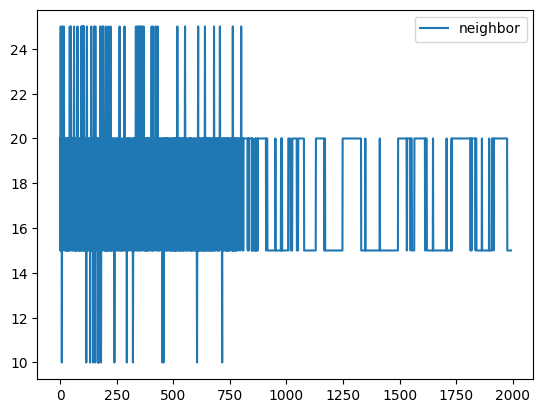

In [13]:
plt.plot(neighbors, label="neighbor")
plt.legend()
plt.show()

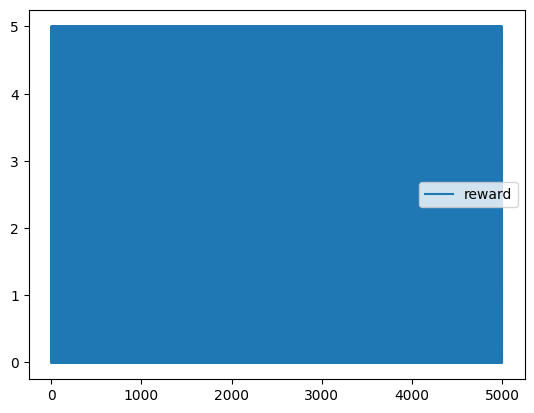

In [14]:

plt.plot(buffer.rews_buf, label="reward")
plt.legend()
plt.show()

In [15]:
compute_total_degree(nx_graph, torch.where(ob == 1)[0].cpu().numpy())

20